# Skin Cancer Classification

## Import Relevant Packages

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import PIL.Image as img
from keras.layers import Dense, Conv2D , MaxPool2D , Dropout , Flatten
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers.experimental import preprocessing
import seaborn as sns
import os
from glob import glob

#### Personal Notes:

I'm a little worried about runtime, so I may make a switch to using grayscale images. RGB is 3 times the size and I'm not sure how that'll play out. Hopefully we don't have to make the compromise, because I think color is important in this data, but I'm keeping it in mind! As an aside, here are what each number in the "label" column corresponds to:
```
0: nv - Melanocytic nevi
1: mel - Melanoma
2: bkl - Benign keratosis-like lesions
3: bcc - Basal cell carcinoma
4: akiec - Actinic keratoses and intraepithelial carcinoma / Bowen's disease
5: vasc - Vascular lesions
6: df - Dermatofibroma
```
The abbreviations are given in the original metadata under the "dx" column; I make these diagnoses clearer in the modified dataset.

## Read in Dataset

In [14]:
data = pd.read_csv("./data/hmnist_28_28_L.csv")
metadata = pd.read_csv("./data/HAM10000_metadata.csv")

# Normalize data:
#data_normalized = data / 255

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


We normalize the dataset because we want to get a value as a *percentage* of brightness, rather than a specific luma key. I've done some analysis on this to know that we don't have any issues, as would be expected for a dataset cultivated for machine learning rather than "real-world" data. I'll likely do more to figure out what kind of distributions exist across cancer type, gender, cancer location, etc. For now though, let's do the fun stuff!

## Metadata Analysis

In [7]:
metadata.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

Good to know! It looks like we've got 57 cases whose age was not recorded. This is a low enough number that I feel comfy replacing these missing ages with the mean age across the whole dataset. I'm using imputation rather than removal because I want to use as much available data as possible. 

In [8]:
# Fill na values "age" variable
metadata["age"].fillna(metadata["age"].mean(), inplace = True)
metadata.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [9]:
# Check work with .describe:
metadata["age"].describe()

count    10015.000000
mean        51.863828
std         16.920252
min          0.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

Interesting... we have some cases where the recorded age is zero!! It's unlikely (I think, at least; I'm not really an expert in pediatric oncology) to have a patient who is truly less than a year old in for skin cancer, so I'm going to assume that these cases are simply a mixup in data entry -- some unknown ages were input as NA, some unknown ages were input as 0. Let's fix that too.

#### First, let's check how many 0s we have....

In [10]:
metadata["age"].value_counts()[0]

39

Well that's okay, only 39 zeros! I wanted to check and make sure -- it's always nasty if they make up some absurd number like 1/2 the dataset!

In [11]:
metadata["age"] = metadata["age"].replace(0, metadata["age"].mean())
metadata["age"].describe()

count    10015.000000
mean        52.065794
std         16.606576
min          5.000000
25%         40.000000
50%         50.000000
75%         65.000000
max         85.000000
Name: age, dtype: float64

In [15]:
data.groupby("label").count()["pixel0001"]

label
0     327
1     514
2    1099
3     115
4    6705
5     142
6    1113
Name: pixel0001, dtype: int64

This data is weighted funny... we'll need to make sure that we find a way around this statistically; too many actinic keratoses cases may skew our predictive capacity. There's got to be a way around it, but I'll check with Cheng on Thursday after class.

Note: Found the solution! I need to come up with a way to select proportionally, or maybe I'll do it with class weights. It might be a little unorthodox to do for a majority column, but we'll give it a go.  

## Merge datasets

I want to make sure that I can keep all data contained in the same dataframe so we can perform a more detailed analysis. I've decided to provide specific names for each skin lesion abbreviation to make my visualizations clearer, and included the image path in the dataframe to make it simpler to find and plot images. I add the label column because each skin lesion is associated with a numeric label code in the pre-built image arrays. In the event I want to use one of these other datasets, I want the switch to be as smooth as possible. Moreover, I will need to one-hot encode the label column to use it in a CNN like I intend to, and readability is helped by making similar changes all at the same time.

In [24]:
# Create lesion type dataset:

cancer_types_dict = {
    "akiec" : "Actinic Keratoses",
    "bcc" : "Basal Cell Carcinoma",
    "bkl" : "Benign Keratosis-like Lesions",
    "df" : "Dermatofibroma",
    "mel" : "Melanoma",
    "nv" : "Melanocytic Nevi",
    "vasc" : "Vascular Lesions"
}

# Create dict of img paths:
base_skin_set = os.getcwd() # this should work for everybody, so long as the file is in the "data" folder!

image_id_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_set, '*', '*.jpg'))} # This is modified stack-overflow code, but it works!

In [27]:
# Create modified dataframe:
mod_data = metadata

mod_data["Cell_Type"] = mod_data['dx'].map(cancer_types_dict.get)
mod_data["Path"] = mod_data["image_id"].map(image_id_path_dict.get)
mod_data["Label"] = pd.Categorical(mod_data['Cell_Type']).codes # Aligns data labels with .csv files in original download
mod_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,Cell_Type,Path,Label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,Benign Keratosis-like Lesions,c:\Users\new owner\Documents\GitHub\fluffy-dis...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,Benign Keratosis-like Lesions,None,2


{'ISIC_0024306': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM10000_images_part_1\\ISIC_0024306.jpg', 'ISIC_0024307': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM10000_images_part_1\\ISIC_0024307.jpg', 'ISIC_0024308': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM10000_images_part_1\\ISIC_0024308.jpg', 'ISIC_0024309': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM10000_images_part_1\\ISIC_0024309.jpg', 'ISIC_0024310': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM10000_images_part_1\\ISIC_0024310.jpg', 'ISIC_0024311': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM10000_images_part_1\\ISIC_0024311.jpg', 'ISIC_0024312': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM10000_images_part_1\\ISIC_0024312.jpg', 'ISIC_0024313': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM10000_images_part_1\\ISIC_0024313.jpg', 'ISIC_0024314': 'c:\\Users\\new owner\\Documents\\GitHub\\fluffy-disco\\HAM1000

### Plot Images From Modified Data

AttributeError: 'NoneType' object has no attribute 'read'

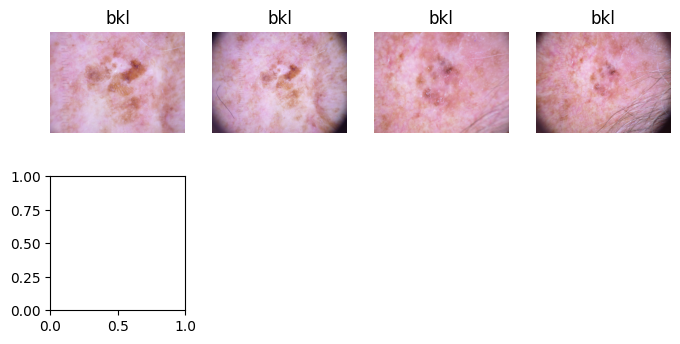

In [23]:
plt.figure(figsize = (8,8))

for i in range(16):
    plt.subplot(4,4, i + 1)
    x = plt.imread(mod_data.Path[i])
    plt.axis("off")
    plt.title(mod_data.dx[i])
    plt.imshow(x)

There we go, clear images of benign lesions that are easy to interpret. This will make life easier when it comes to displaying interesting images in the future, and gives us a clear path to building the CNN; we only need to import the image with the path, convert to np array, and reshape for computational efficiency.

### Train / Test Split and Image Conversion.


In [ ]:
# Drop label columns:
features = mod_data.drop(columns = ["Label", "Cell_Type", "dx"], axis = 1)

# Define Labels for Supervised Learning
target = mod_data["Label"]

X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size = .3, random_state = 1729) #Points if you know the significance of this number!

We've gotten everything split properly now (and consistently!), we now need to resize and normalize the images. 

In [ ]:
# Let's check image size, just to be sure:
image = img.open(X_train["Path"][0])
print(f"Image Size: {image.size}")

### Warning: The code below takes approximately 3 minutes to run totally

In [ ]:
# Resize images to 128 x 128
X_test["Image"] = X_test["Path"].map(lambda x: np.asarray(img.open(x).resize((128,128))))
X_train["Image"] = X_train["Path"].map(lambda x: np.asarray(img.open(x).resize((128,128))))

X_test["Image"].head()

In [ ]:
# Check image shape after resizing...
X_test['Image'].map(lambda x: x.shape).value_counts()

We've got the data resized and stored as numpy arrays, now let's move to normalizing the image:

In [ ]:
# Define number of classes
CLASSES = len(np.unique(Y_train))

# One-hot encode labels
Y_train = to_categorical(Y_train, num_classes = CLASSES)
Y_test = to_categorical(Y_test, num_classes = CLASSES)

In [ ]:
# Define Image Generator
x = X_test["Image"]
train_image_generator = keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
x.head()

Class weights work as follows: They calculate the inverse proprotion of model frequency, as shown below.
\begin{equation*}
\frac{n_{samples}}{n_{classes} \cdot \operatorname{bincount}(y)}
\end{equation*}

"a" in this function refers to the constant by which we scale the frequencies

### Read in Files w/ glob
glob is used to find files matching a certain path; in this case, image files 1 & 2. I use a wildcard (denoted by the asterisk) to pull *everything* in the file path with a ".jpg", and split the data into test and train accordingly. The data comes to us separated into train and test sets, at the moment, I'm not going to change it. So, I assign everything in file 1 to "train_image_names", and everything in file 2 to "test_image_names". An example of how a name is stored is shown here: 
```
'HAM10000_images_part_1\\ISIC_0024306'
```
.rindex() works almost exactly like .rfind(), except it raises an exception if the value isn't found instead of returning -1. Here I use it to find the last backslash in the image file name, then use indexing to isolate the name itself.

In [ ]:
# Training Image Assignment
image_names_p1 = glob('./data/HAM10000_images_part_1/*.jpg')
train_image_names = [image[image.rindex('/')+1:-4] for image in image_names_p1]

# Testing Image Assignment
image_names_p2 = glob('./data/HAM10000_images_part_2/*.jpg')
test_image_names = [image[image.rindex('/')+1:-4] for image in image_names_p2]

Well this is cool! I really love being able to take a look at what the computer "sees" when I give it the matrix. I also just noticed something about the data that I'll have to fix -- I normalized EVERY column in the dataset, including the label column. Probably a good idea to fix that little issue...